Stokes-Einstein Breakdown
==============

One of the major results that we observe
is what appears to be a breakdown 
in the Stokes-Einstein relationship,
most likely brought about by the reversibility of
the motions that take place.
As a result of this it would be nice to have
a figure that demonstrates this breakdown
with reference to individual particle motions,
since it is the motion of individual particles
that are the cause of this breakdown.

As an individual particle property,
we really only want to follow a smallish number of particles,
probably from a single trajectory.
To have the largest likelihood of 
finding something interesting,
I will be using the dynamics from T=1.30, P=13.50.

Data Ingest/Calculation
----------------------

I don't have the translations and rotations from
every timepoint saved anywhere,
so I will have to generate all the data
from the trajectories.

In [11]:
from pathlib import Path

import gsd.hoomd
import pandas
import numpy as np

import matplotlib.pyplot as plt
import altair

from sdanalysis.dynamics import dynamics, molecularRelaxation, lastMolecularRelaxation
from sdanalysis.StepSize import GenerateStepSeries
import sdanalysis

import altair as alt

### Loading Data

There are a few differences with the data used for this analysis
due to the different nature of the figures presented.

The file that we are interested in is the dump file which has linear timesteps
rather than the exponential series in the trajectory files.
The reason for the linear series is that we are interested in
following the motion of the particle through many environments,
requiring short steps for all the different environments.
Additionally there is no complication with working out
which of the series that each configuration belongs to.

Along with the trajectory, 
I am loading up the dynamics computed previously.
However rather than all the dynamics,
I am only loading up those from the first keyframe.
This is because these are the dynamic quantities that
correspond to the data loaded from the trajectory. 

In [2]:
pressure = '13.50'
temperature = '1.35'
directory = Path("../data/simulations/trimer/output/")
# Load up a linear trajectory for ease of analysis 
file = directory / f'trajectory-Trimer-P{pressure}-T{temperature}.gsd'
stem = f'Trimer-13.50-{temperature}'
# # Read in pre-computed dynamics properties for a single trajectory 
# dynamics_df = pandas.read_hdf(directory / 'dynamics' / f'trajectory-13.50-{temperature}.hdf5',
#                               'relaxations').loc[0, :]
# # Find the fastest particles
# fastest = dynamics_df.sort_values('tau_D1').head(5).index.values

### Computation of Dynamics

The values of the dynamics we have calculated previously have been using an exponential timescale, which while great for the more traditional dynamics quantities becomes unhelpful in computing the molecular quantities and the analysis that will be presented in the rest of this document.

I have stored the configuration at a series of linear steps and so the below analysis computes the molecular relaxations at a single temperature (1.30) using this linear scale, while also computing the displacement and rotation at each point in time allowing for the querying of the resulting dataset.

The data is stored in a sqlite database as this is a highly queryable format while still remaining compatible with a range of systems.

In [3]:
max_steps = None
recompute = False
# Uncomment to recompute quantities this takes a long time to compute
# recompute = True
if recompute:
    dataframes = []
    
    with gsd.hoomd.open(str(file)) as trj:
        # Read the first frame of the snapshot to set up dynamics
        snap = sdanalysis.HoomdFrame(trj[0])
        num_mols = snap.num_mols
        dyn = dynamics(
            timestep=snap.timestep,
            box=snap.box,
            position=snap.position,
            orientation=snap.orientation,
        )
        first_passage = molecularRelaxation(num_mols, 0.4)
        last_passage = lastMolecularRelaxation(num_mols, 0.4, 1.0)
        exists = False
        for snap in trj:
            delta_time = dyn.computeTimeDelta(snap.configuration.step).astype(np.int32)
            delta_disp = dyn.get_displacements(snap.particles.position[:num_mols])
            dataframes.append({
                'mol_index': snap.particles.body[:num_mols].astype(np.uint16),
                'time': delta_time.astype(np.uint32),
                'displacement': delta_disp.astype(np.float32),
                'rotation': dyn.get_rotations(snap.particles.orientation[:num_mols]).astype(np.float32),
            })
            exists = True
            first_passage.add(delta_time, delta_disp)
            last_passage.add(delta_time, delta_disp)
            if max_steps and snap.configuration.step > max_steps:
                break
    pdf = pandas.DataFrame({
        'first_passage': first_passage.get_status(),
        'last_passage': last_passage.get_status(),
    })
    # Write data to files
    df = pandas.concat([pandas.DataFrame(data) for data in dataframes])
    df.to_hdf(f'{stem}.h5', 'single_motion')
    pdf.to_hdf(f'{stem}.h5', 'passage_times')
else:
    df = pandas.read_hdf(f'{stem}.h5', 'single_motion')
    pdf = pandas.read_hdf(f'{stem}.h5', 'passage_times')

In [4]:
df.set_index(['mol_index', 'time'], inplace=True, drop=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121638750 entries, (0, 0) to (624, 1000000000)
Data columns (total 4 columns):
mol_index       uint16
time            uint32
displacement    float32
rotation        float32
dtypes: float32(2), uint16(1), uint32(1)
memory usage: 2.3 GB


In [8]:
# Molecules for selection 
selected = [120, 130, 140]
df_fast = df.loc[selected]

In [9]:
df_fast.head()

,,mol_index,time,displacement,rotation
mol_index,time,,,,
120,0,120,0,0.000000,0.000000
130,0,130,0,0.000000,0.000000
140,0,140,0,0.000000,0.000000
120,1,120,1,0.004391,0.001102
130,1,130,1,0.002589,0.003046


In [10]:
df_fast = df_fast.set_index(pandas.TimedeltaIndex(df_fast['time'], unit='ns'))
df_fast_groups = df_fast.groupby('mol_index').resample('1ms')

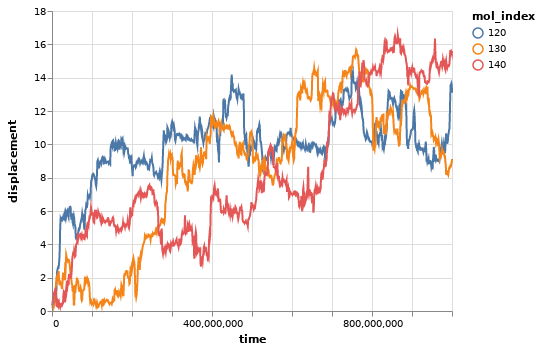

In [18]:
alt.Chart(df_fast_groups.mean().reset_index(drop=True)).mark_line().encode(
    x='time',
    y='displacement',
    color='mol_index:N'
)

In [ ]:
%%opts Path [color_index='time'] (line_width=1 cmap='viridis' alpha=0.5)

mol_id = 120

df_path = df_fast.loc[df_fast.mol_index.values == mol_id, :].copy()
# df_path.loc[:, 'time'] = np.log(df_path.loc[:, 'time'].values)
hv.Path([df_path], kdims=['displacement', 'rotation'], vdims=['time']) * hv.VLine(1)

In [20]:
pdf.sort_values('last_passage')
pdf = pdf[pdf.last_passage != 2**32-1]

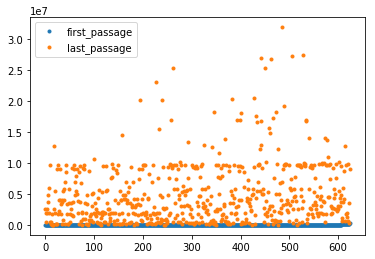

In [22]:
fig, ax = plt.subplots()
ax.plot(pdf.sort_values('first_passage').reset_index(drop=True).first_passage, '.')
ax.plot(pdf.sort_values('first_passage').reset_index(drop=True).last_passage, '.')
ax.legend()
ax.set_yscale('linear')
fig.savefig('passage_times.pdf')

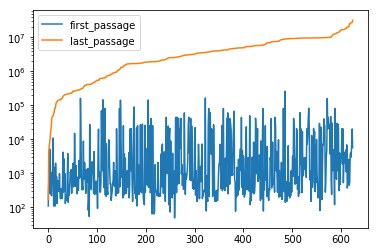

In [23]:
pdf.sort_values('last_passage').reset_index(drop=True).plot(logy=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121638750 entries, (0, 0) to (624, 1000000000)
Data columns (total 4 columns):
mol_index       uint16
time            uint32
displacement    float32
rotation        float32
dtypes: float32(2), uint16(1), uint32(1)
memory usage: 2.3 GB


In [25]:
rotations_first = []
rotations_last = []
for index, first, last in pdf.itertuples():
    if last == 2**32 - 1:
        continue
    rotations_first.append(df.loc[index, first].rotation)
    rotations_last.append(df.loc[index, last].rotation)

In [26]:
rot_first = np.array(rotations_first)
rot_last = np.array(rotations_last)
rotations = pandas.DataFrame({
    'first passage': rot_first,
}).melt().append(pandas.DataFrame({
    'last passage': rot_last
}).melt())

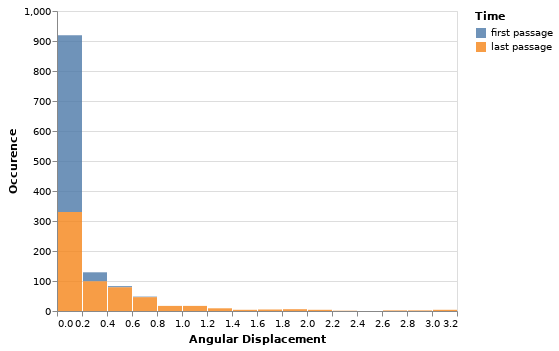

In [31]:
altair.Chart(rotations).mark_bar(opacity=0.8).encode(
    x=altair.X('value:Q', title='Angular Displacement', bin=altair.Bin(maxbins=20)),
    y=altair.Y('count():Q', title='Occurence'),
    color=altair.Color('variable', title='Time'),
)

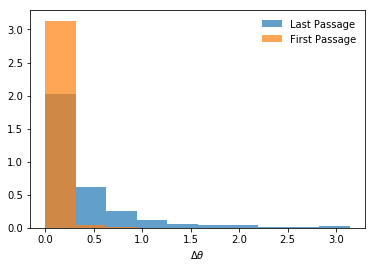

In [36]:
fig, ax = plt.subplots()
ax.hist(rot_last, range=(0, np.pi), density=True, alpha=0.7, label="Last Passage")
ax.hist(rot_first, range=(0, np.pi), density=True, alpha=0.7, label="First Passage")
ax.legend(frameon=False)
ax.set_xlabel(r'$\Delta\theta$')
fig.savefig(f'Rotational_disp-{stem}.pdf')